# Identifying Fraud from Enron Email
The aim of this project to identify person of interest (poi) in Enron scandal from a given dataset.
Original dataset and starter's code can be downloaded from [this github repository](https://github.com/udacity/ud120-projects.git).

The analysis is performed with the following procedure. We start with an exploratory analysis and then we clean the dataset based on some observations. After that, we add some new features into the dataset. Finally, we select features and run a couple of machine learning algrithms to identify ```poi```.

## Table of contents

[Exploratory Analysis](#Exploratory-Analysis)

[Removing outliers](#Removing-outliers)

[Selecting features manually](#Selecting-features-manually)

[Engineering new features](#Engineering-new-features)

[Feature Selection](#Feature-selection)

[Models of classification](#Models-of-classification)

[More details on the validation of the models](#More-details-on-the-validation-of-the-models)

[Conclusion](#Conclusion)

## About this implementation
This implementation takes a slightly different approach compared with the starter's code. We first convert the raw data file ```final_project_dataset.pkl``` into a pandas dataframe object. Most of the exploratory analysis and operations of this dataset were performed using pandas library. This ipython notebook was tested using python 3.4.

```final_project_dataset.pkl```: the original dataset. 

```scoring.py```: this file contains the function for evaluating the classification results.
- ```calc_score()```: this function uses the same method as ```test_classifier``` in the starter's code to evalulate precision, recall and f1 scores.

```preprocess_data.py```: this file contains the functions that do the preprocessing of the raw data.
- ```pkl_to_df()```: Read the raw pkl file and convert the contents in the pkl file into a python dataframe.
- ```extract_df()```: Return the features and labels in the dataframe as numpy arrays.
- ```FeatureSel```: A class that selects the features using ```SelectKBest``` and ```PCA``` in ```sklearn```.
- ```add_feature()```: This function takes logarithms of the financial features.

```poi_id.py```: the mail file that does the classification. This is the final submission file for the project.


In [34]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale,StandardScaler,Imputer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

from scoring import calc_score
from preprocess_data import pkl_to_df,extract_df,linearsvc_outlier_rm,FeatureSel,add_features

## Exploratory Analysis
In this section, we loads the data and explore some basic information of this dataset. Since the values in the feature *"email_address"* are string, we will exclude this feature throughout our analysis.

In [35]:
# Load the dataset and convert it to a pandas dataframe
df=pkl_to_df(rows_to_remove=[],cols_to_remove=["email_address"])
df=df.convert_objects(convert_numeric=True)

#### Dimension of the data

In [36]:
df.shape

(146, 20)

In [37]:
df.columns

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'poi', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

This data set has 145 entries and 21 features, including ```poi```. Note that we have already excluded "email_address" in the dataframe ```df```.

#### Statistics of dependent variable ```poi```
We now use ```describe()``` function to explore the summary of the feature ```poi```:

In [38]:
df["poi"].describe()

count          146
mean     0.1232877
std      0.3298989
min          False
25%              0
50%              0
75%              0
max           True
Name: poi, dtype: object

The mean value indicates that only 12.4% of ```poi``` is ```True```. In the above result, ```count``` is the number of total non-NaN values. The ```count``` of ```poi``` equals to the total rows, showing that every row has a ```poi``` value.

#### NaN in each feature
We can then use ```transpose()``` and ```count``` to explore the ratio of non-NaN values in each feature: 

In [39]:
df.describe().transpose()["count"]/df.shape[0]

bonus                         0.5616438
deferral_payments             0.2671233
deferred_income               0.3356164
director_fees                 0.1164384
exercised_stock_options       0.6986301
expenses                      0.6506849
from_messages                 0.5890411
from_poi_to_this_person       0.5890411
from_this_person_to_poi       0.5890411
loan_advances                0.02739726
long_term_incentive           0.4520548
other                         0.6369863
poi                                   1
restricted_stock              0.7534247
restricted_stock_deferred     0.1232877
salary                        0.6506849
shared_receipt_with_poi       0.5890411
to_messages                   0.5890411
total_payments                0.8561644
total_stock_value             0.8630137
Name: count, dtype: object

This result shows that every feature has NaN values except ```poi```. The feature ```loan_advances``` has the lowest ratio of non-NaN data, which is only 2%. In the following analysis, we will treat these NaN as zero.

## Using random forests to classify the raw dataset
We now set up a random forests classifier to test the results of the classificaion at each stage of data preprocessing.

In [40]:
rf_dict=[] # a list of dictionary that stores the results
rf=RandomForestClassifier()
df.fillna(0,inplace=True)
X,y,_=extract_df(df)
score=calc_score(X,y,rf)
score_dict={"data":"raw","dataframe":"df"}
score_dict.update(score)
rf_dict.append(score_dict)

precision: 0.2852983988355167
recall: 0.098
f1: 0.14588760699665054


## Removing outliers

In this section, we will remove the data points that may not be appropriate to include for further analysis.
As discussed in the mini-project of the course, the dataset includes an entry that is the total of the financial features. Therefore we should remove this entry *TOTAL* before further analyzing the data. Also, we found that all the features of *LOCKHART EUGENE E* are NaN except ```poi```. Thus it makes sense to remove this data entry as well.

In [41]:
df.loc["LOCKHART EUGENE E",:]

bonus                            0
deferral_payments                0
deferred_income                  0
director_fees                    0
exercised_stock_options          0
expenses                         0
from_messages                    0
from_poi_to_this_person          0
from_this_person_to_poi          0
loan_advances                    0
long_term_incentive              0
other                            0
poi                          False
restricted_stock                 0
restricted_stock_deferred        0
salary                           0
shared_receipt_with_poi          0
to_messages                      0
total_payments                   0
total_stock_value                0
Name: LOCKHART EUGENE E, dtype: object

Here we will remove both *TOTAL*,*LOCKHART EUGENE E* and see how it affect the results of random forests classifier.

In [42]:
rows_to_remove=["TOTAL","LOCKHART EUGENE E"]
ro_df=pkl_to_df(rows_to_remove=rows_to_remove)
ro_df=ro_df.convert_objects(convert_numeric=True)
X,y,_=extract_df(ro_df.fillna(0))
score=calc_score(X,y,rf)
score_dict={"data":"removing outlier manually","dataframe":"ro_df"}
score_dict.update(score)
rf_dict.append(score_dict)

precision: 0.3701492537313433
recall: 0.124
f1: 0.18576779026217227


This result shows that all the scores slightly improved after the outliters are removed.

## Selecting features manually
First we use ```describe()``` to list the basic statistical information of each feature.

In [43]:
ro_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,81,1201773,1441679,70000,425000,750000,1200000,8000000
deferral_payments,38,841602.5,1289323,-102500,79644.5,221063.5,867211.2,6426990
deferred_income,48,-581049.8,942076.4,-3504386,-611209.2,-151927,-37926,-833
director_fees,16,89822.88,41112.7,3285,83674.5,106164.5,112815,137864
exercised_stock_options,101,2959559,5499450,3285,506765,1297049,2542813,3.434838e+07
expenses,94,54192.01,46108.38,148,22479,46547.5,78408.5,228763
from_messages,86,608.7907,1841.034,12,22.75,41,145.5,14368
from_poi_to_this_person,86,64.89535,86.97924,0,10,35,72.25,528
from_this_person_to_poi,86,41.23256,100.0731,0,1,8,24.75,609
loan_advances,3,2.7975e+07,4.638256e+07,400000,1200000,2000000,4.17625e+07,8.1525e+07


From the above result, we noticed that only three entries of the feature *loan_advances* has values, it is reasonable to ignore this feature to reduce the variances in the model. The following test shows that leaving out this feature for classification increase the overall precision, recall and f1 scores a little bit.

In [44]:
sf1_df=ro_df.drop(["loan_advances"],axis=1)
sf1_df=sf1_df.convert_objects(convert_numeric=True)
sf1_df=ro_df.copy()
X,y,_=extract_df(sf1_df.fillna(0))
score=calc_score(X,y,rf)
score_dict={"data":"removing loan_advances","dataframe":"sf1_df"}
score_dict.update(score)
rf_dict.append(score_dict)

precision: 0.363914373088685
recall: 0.119
f1: 0.17935192162773173


## Engineering new features

We noticed that many financial features in this dataset has very wide range. The difference can be several orders of magnitudes. This distribution can potentially biased the results of classifications. Take the feature ```exercised_stock_options``` for example:

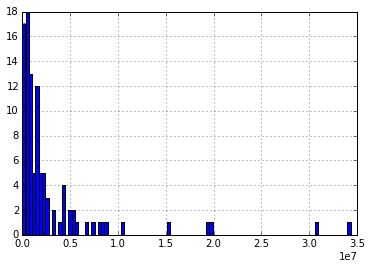

In [45]:
f="exercised_stock_options"
sf1_df[f].hist(bins=100)

In the above figure, we can see a long tail at large values of ```exercised_stock_options```. Taking logarithms of the feature ```exercised_stock_options``` makes the distribution less skewed:

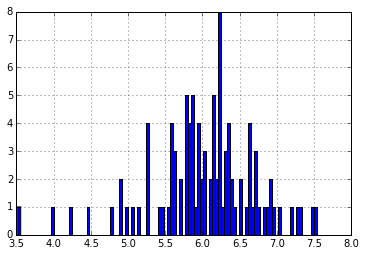

In [46]:
np.log10(sf1_df[f]).hist(bins=100)

In this way, we can keep the data with extreme values but reduces its impact on classification. Since we can only perform logarithms on postive numbers, we thus adopt the following tricks to deal with zeros and negative numbers.
1. Filling NaN or zeros values in raw data with zeros in the logarithmic features. We can do this because the financial features can never be less than 1 ($10^0$). Also, 0 and 1 have no substantial differences in these financial features.
2. If a financial feature has negative values, we convert it into two features. One stores the positive values, and another store the negative values. For example, ```p_total_stock_value``` stores postivie values of ```total_stock_value```, while ```n_total_stock_value``` stores negative values of ```total_stock_value```.

These operations are implemented in ```add_features()``` in ```preprocess_data.py```. Since we make this function compatible with the data structure used in ```poi_id.py```, we have to reload the raw data file, perform ```add_features()```, and converti it to pandas dataframe again.

In [47]:
pkl_file="./data/final_project_dataset.pkl"
data_dict=pickle.load(open(pkl_file,"rb"),fix_imports=False,encoding="latin1")

# Features to be included. Everything except "email_address" and "loan_advances"
features_list = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees',
                 'exercised_stock_options', 'expenses', 'from_messages',
                 'from_poi_to_this_person', 'from_this_person_to_poi',
                 'long_term_incentive', 'other', 'restricted_stock',
                 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
                 'to_messages', 'total_payments', 'total_stock_value']

# Delete the outliers
del data_dict["TOTAL"]
del data_dict["LOCKHART EUGENE E"]

# Take logarithms of finanacial features
my_dataset, new_feature_names, financial_features = add_features(data_dict)

# Convert the data to pandas dataframe
sf2_df=pd.DataFrame(data_dict)
sf2_df=sf2_df.convert_objects(convert_numeric=True)
sf2_df=sf2_df.transpose()

Again, we test this processed dataset using random forests:

In [48]:
X,y,_=extract_df(sf2_df.fillna(0))
score=calc_score(X,y,rf)
score_dict={"data":"adding new features","dataframe":"sf2_df"}
score_dict.update(score)
rf_dict.append(score_dict)

precision: 0.3885630498533724
recall: 0.1325
f1: 0.197613721103654


All the scores are slightly improved by using the new preprocessed dataset.
## Summary of results of random forests
Here we summarize the the results of each stage of data preporocessing using random forests classifier in the following table. The variation of *precision*, *recall* and *f1* are +/- 0.01. These scores are caculated by summing TP, TF, FP, FN 1000 times using stratified cross validation. This procedure is identical to the scoring function provided by the startup code.

In [49]:
rf_score_df=pd.DataFrame(rf_dict)
rf_score_df

,data,dataframe,f1,precision,recall
0,raw,df,0.145888,0.285298,0.0980
1,removing outlier manually,ro_df,0.185768,0.370149,0.1240
2,removing loan_advances,sf1_df,0.179352,0.363914,0.1190
3,adding new features,sf2_df,0.197614,0.388563,0.1325


## Feature selection
We combine two approaches to select features for training, one is univariate feature selection, and the other is principle component analysis. We select *m* features using ```SelectKBest``` is sklearn and select another *n* features using ```pca```, and then use these *m+n* features for classification. The values of *m* and *n* will be chosen by cross-validation. We wrap these process into the class ```FeatureSel```, which is compatible with standards defined by *sklearn* so that we can incorporate it into a sklearn ```Pipeline```. The implementation of this class is in [preprocess_data.py](./preprocess_data.py)


## Models of classification

### Procedures of running the classification
We will run three classification models: linear support vector machine(```LinearSVC```) and AdaBoost (```AdaBoostClassifier```). We use ```Pipeline``` class in sklearn to combine these algorithms with our ```FeatureSel``` class. A ```Pipeline``` has the following three components:

1. ```FeatureSel```: As mentioned in the previous section, this class select and combines the features yielded by ```SelectKBest``` and ```pca```.
2. ```StandardScaler```: Rescle the data if it is necessary for the classifier.
3. ```ChoiceOfClassifier```: The main algorithm for calssification.

### Tuning the model with cross validation
We also set up a ```GridSearchCV``` class that scans some key parameter to fine tune the model. From those preliminary tests using random forests, we find that the values of *precision* can easily meet the specification but the values of *recall* are low. Thus we will set our ```GridSearchCV``` objects to optimize *recall*.
### LinearSVC
First we use linear support vector machine (```LinearSVC```) to do the classification on both the dataset that with and without feature engineering. The parameters that we choose to optimize are C value of ```LinearSVC``` and the number of components selected by ```SelectKBest``` and ```pca```. C value is a regularization parameter. Larger C gives lower bias but higher variance, whereas smaller C gives higher bias but lower variance on the classification results.

#### LinearSVC with the data without feature engineering, with feature selection

In [50]:
clf_dict=[] # A list that stores the test conditions and scores
fill_test_df=sf1_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
fsl=FeatureSel(k_best=5,pca_comp=5)
sd=StandardScaler()
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",LinearSVC())])
gscv=GridSearchCV(ppl,{"lvc__C":np.logspace(-6,-1,5),
                  "fsl__k_best":[1,5,10],"fsl__pca_comp":[0,5,10]},
                  scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv.best_estimator_,n_iter=100)
score_dict={"dataframe":"sf1_df",
            "feature engineering":False,
           "feature selection":True,
           "algorithm":"LinearSVC"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('fsl', FeatureSel(k_best=1, pca_comp=0)), ('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lvc', LinearSVC(C=9.9999999999999995e-07, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='l2', multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
precision: 0.37244897959183676
recall: 0.3285
f1: 0.34909670563230605


#### LinearSVC with the data without feature engineering, without feature selection

In [51]:
fill_test_df=sf1_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
sd=StandardScaler()
ppl_nofsl=Pipeline([("sd",sd),("lvc",LinearSVC())])
gscv=GridSearchCV(ppl_nofsl,{"lvc__C":np.logspace(-6,-1,10)},scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv.best_estimator_,n_iter=100)
score_dict={"dataframe":"sf1_df",
            "feature engineering":False,
           "feature selection":False,
           "algorithm":"LinearSVC"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lvc', LinearSVC(C=9.9999999999999995e-07, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='l2', multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
precision: 0.2608843537414966
recall: 0.3835
f1: 0.3105263157894737


#### LinearSVC with the dataset with feature engineering, with feature selection

In [52]:
fill_test_df=sf2_df.fillna(0)
nX2,ny,cols=extract_df(fill_test_df)
fsl=FeatureSel(k_best=5,pca_comp=5)
sd=StandardScaler()
ppl=Pipeline([("fsl",fsl),("sd",sd),("lvc",LinearSVC())])
gscv=GridSearchCV(ppl,{"lvc__C":np.logspace(-6,-1,5),
                       "fsl__k_best":[1,5,10],
                       "fsl__pca_comp":[0,5,10]},
                  scoring="recall",verbose=0)
gscv.fit(nX2,ny)
print(gscv.best_estimator_)
score=calc_score(nX2,ny,gscv.best_estimator_,n_iter=100)
score_dict={"dataframe":"sf2_df",
            "feature engineering":True,
           "feature selection":True,
           "algorithm":"LinearSVC"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('fsl', FeatureSel(k_best=1, pca_comp=0)), ('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lvc', LinearSVC(C=9.9999999999999995e-07, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='l2', multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
precision: 0.3839378238341969
recall: 0.3705
f1: 0.37709923664122136


#### LinearSVC with the dataset with feature engineering, without feature selection

In [53]:
fill_test_df=sf2_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
sd=StandardScaler()
ppl_nofsl=Pipeline([("sd",sd),("lvc",LinearSVC())])
gscv=GridSearchCV(ppl_nofsl,{"lvc__C":np.logspace(-6,-1,5)},scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv,n_iter=100)
score_dict={"dataframe":"sf2_df",
            "feature engineering":True,
           "feature selection":False,
           "algorithm":"LinearSVC"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lvc', LinearSVC(C=9.9999999999999995e-07, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='l2', multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
precision: 0.2916147409649279
recall: 0.819
f1: 0.4300905868452147


### AdaBoost classification
We will also try AdaBoost and see if it can outperforms the reusults given by LinearSVC. The pipeline we set up is almost the same as the one we used in previous section, except that we repalce ```LinearSVC``` by ```AdaBoostClassifier```.

The parameter that we will tune is the learning rate. This parameter controls how much the model is adjusted after each iteration. 

#### Test the dataset with feature engineering, with feature selection

In [54]:
fill_test_df=sf2_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
fsl=FeatureSel(k_best=5,pca_comp=5)
sd=StandardScaler()
ppl=Pipeline([("fsl",fsl),('sd',sd),("rf",AdaBoostClassifier())])
gscv=GridSearchCV(ppl,{"rf__learning_rate":np.logspace(-6,0,5),
                       "fsl__k_best":[1,5,10],"fsl__pca_comp":[0,5,10]},
                  scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv.best_estimator_)
score_dict={"dataframe":"sf2_df",
            "feature engineering":True,
           "feature selection":True,
           "algorithm":"AdaBoost"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('fsl', FeatureSel(k_best=1, pca_comp=0)), ('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=9.9999999999999995e-07, n_estimators=50,
          random_state=None))])
precision: 0.21359223300970873
recall: 0.066
f1: 0.10084033613445378


#### Test the dataset with feature engineering, without feature selection

In [55]:
fill_test_df=sf2_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
fsl=FeatureSel(k_best=5,pca_comp=5)
sd=StandardScaler()
ppl=Pipeline([('sd',sd),("rf",AdaBoostClassifier())])
gscv=GridSearchCV(ppl,{"rf__learning_rate":np.logspace(-6,0,5)},scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv.best_estimator_)
score_dict={"dataframe":"sf2_df",
            "feature engineering":True,
           "feature selection":False,
           "algorithm":"AdaBoost"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.031622776601683791, n_estimators=50,
          random_state=None))])
precision: 0.5714285714285714
recall: 0.106
f1: 0.17882749894559258


#### Test dataset without feature engineering, without feature selection

In [56]:
fill_test_df=sf1_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
fsl=FeatureSel(k_best=5,pca_comp=5)
sd=StandardScaler()
ppl=Pipeline([("sd",sd),("rf",AdaBoostClassifier())])
gscv=GridSearchCV(ppl,{"rf__learning_rate":np.logspace(-6,0,5)},scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv.best_estimator_)
score_dict={"dataframe":"sf1_df",
            "feature engineering":False,
           "feature selection":False,
           "algorithm":"AdaBoost"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
precision: 0.39927007299270073
recall: 0.2735
f1: 0.32462908011869435


#### Test dataset without feature engineering, with feature selection

In [57]:
fill_test_df=sf1_df.fillna(0)
nX,y,cols=extract_df(fill_test_df)
fsl=FeatureSel(k_best=5,pca_comp=5)
sd=StandardScaler()
ppl=Pipeline([("fsl",fsl),("sd",sd),("rf",AdaBoostClassifier())])
gscv=GridSearchCV(ppl,{"rf__learning_rate":np.logspace(-6,0,5),
                       "fsl__k_best":[1,5,10],"fsl__pca_comp":[0,5,10]},
                  scoring="recall",verbose=0)
gscv.fit(nX,y)
print(gscv.best_estimator_)
score=calc_score(nX,y,gscv.best_estimator_)
score_dict={"dataframe":"sf1_df",
            "feature engineering":False,
           "feature selection":True,
           "algorithm":"AdaBoost"}
score_dict.update(score)
clf_dict.append(score_dict)

Pipeline(steps=[('fsl', FeatureSel(k_best=1, pca_comp=0)), ('sd', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
precision: 0.30787781350482313
recall: 0.1915
f1: 0.23612823674475955


### Scores of the classification algorithms
The scores of the above algorithms are listed in the following table. Due to the randomness of cross-validation, the variation of each scores listed in the table are around +/- 0.02.

In [58]:
clf_df=pd.DataFrame(clf_dict)
clf_df

,algorithm,dataframe,f1,feature engineering,feature selection,precision,recall
0,LinearSVC,sf1_df,0.349097,False,True,0.372449,0.3285
1,LinearSVC,sf1_df,0.310526,False,False,0.260884,0.3835
2,LinearSVC,sf2_df,0.377099,True,True,0.383938,0.3705
3,LinearSVC,sf2_df,0.430091,True,False,0.291615,0.8190
4,AdaBoost,sf2_df,0.100840,True,True,0.213592,0.0660
5,AdaBoost,sf2_df,0.178827,True,False,0.571429,0.1060
6,AdaBoost,sf1_df,0.324629,False,False,0.399270,0.2735
7,AdaBoost,sf1_df,0.236128,False,True,0.307878,0.1915


## More details on the validation of the models
We implement ```calc_score()``` to evaluate the performance of our algorithms. ```calc_score()``` runs stratified cross validation for 1000 times. For each run, it takes 10% of the data as the test dataset and the remaining 90% of the data as the training dataset. After the model is fitted using the training set, it tests the model with the test set and calculate the number of true posivies (TP), false positives (FP), false negatives (FN) and true negatives (TN). After these iterations finish, it sums up the TP, FP, FN and TN of all iterations, and then calculate recall, precision and f1 score.

We adopt this method instead of averaging each metric such as recall or precision because this dataset is small and the portions of the ```poi=True``` is only 10%. Therefore, variations of the scoring metrics between each run would be very large.

The three metrics we used are defined as below: 

- *precision* measures the ratio of TP among all the population that are predicted as ```poi```, namely,

\begin{align}
precision=\frac{TP}{TP+FP}
\end{align}

- *recall* measures the ratio of TP among all the population that are ```poi```, namely,

\begin{align}
recall=\frac{TP}{TP+FN}
\end{align}

*Precision* and *recall* are chosen to be the metrics instead of *accuracy* because the population of ```poi=True``` are small, and *accuracy* cannot reflect the real predictive power of our model.


- *f1 score* is the harmonic mean of *precision* and *recall*:
\begin{align}
f1= \frac{2 \cdot precision \cdot recall}{precision+recall}
\end{align}

This metric can be considered as a kind of average of *precision* and *recall*.

By using these metrics to evaluate our model, the most performant model are linearSVC, with or without feature engineering.

## Conclusion
In this report, we demonstrated a model to predict ```poi``` in the Enron dataset that could achieve f1 scores larger than 0.3. We first remove a couple of data entries that are not appropriate for further analysis, and exclude a feature that are mostly NaNs. After that, we use both univariate method and principle component analysis as the way to select features. Finally, we use AdaBoost and linear support vector machine to predict ```poi```. Cross-validation shows that linear support vector machine is more accurate in predicting ```poi```, giving f1 scores over 0.3.